## Import

In [1]:
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)



torch:  2.0 ; cuda:  2.0.1
detectron2: 0.6


In [2]:

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import torch
from source.data_utils import *

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.evaluation import COCOEvaluator

from detectron2.data import DatasetCatalog, MetadataCatalog


     


## Register the SODA10M dataset

In [3]:
import os
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo


# Register the COCO dataset from the custom path
# Assuming you have "instances_train.json" and "instances_val.json" in the directory
# Update these json file names if yours are different
register_coco_instances("soda10m_train", {}, 
                        "SSLAD-2D/labeled/annotations/instance_train.json", 
                        "SSLAD-2D/labeled/train")
register_coco_instances("soda10m_val", {}, 
                        "SSLAD-2D/labeled/annotations/instance_val.json", 
                        "SSLAD-2D/labeled/val")
register_coco_instances("soda10m_test", {}, 
                        "SSLAD-2D/labeled/annotations/instance_test.json", 
                        "SSLAD-2D/labeled/test")
# Call this function with the path to your original and new subset JSON files
#create_val_subset("SSLAD-2D/labeled/annotations/instance_val.json","SSLAD-2D/labeled/annotations/instance_val_subset.json",1000)
#create_val_subset("SSLAD-2D/labeled/annotations/instance_test.json","SSLAD-2D/labeled/annotations/instance_test_subset.json",2500)
#Subset of 1000 images


In [4]:
register_coco_instances("soda10m_val_subset", {}, 
                        "SSLAD-2D/labeled/annotations/instance_val_subset.json", 
                        "SSLAD-2D/labeled/val")

register_coco_instances("soda10m_test_subset", {}, 
                        "SSLAD-2D/labeled/annotations/instance_test_subset.json", 
                        "SSLAD-2D/labeled/test")

## Training

In [5]:

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
    
    @classmethod
    def get_evaluator(cls, cfg, dataset_name, output_folder=None):
        # This method returns the evaluator instance
        return cls.build_evaluator(cfg, dataset_name, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks
    

In [ ]:
from detectron2.data.samplers import RandomSubsetTrainingSampler
from detectron2.data import build_detection_test_loader   # the default mapper
from detectron2.evaluation import inference_on_dataset




cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))


cfg.MODEL.DEVICE = "cuda"
# Update the dataset names to the registered names
cfg.DATASETS.TRAIN = ("soda10m_train",)
cfg.DATASETS.TEST = ("soda10m_val_subset",)  # or an empty tuple if you don't have a validation set


cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
#cfg.MODEL.WEIGHTS = r"C:\Users\melmourabitagharbi\detectron2\detectron2\checkpoint\faster_rcnn_R_101_FPN_3x\model_final_f6e8b1.pkl"
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.MAX_ITER = 50000
cfg.SOLVER.STEPS = []  # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Number of classes in SODA10m

cfg.TEST.EVAL_PERIOD = 5000


#num_gpu = 1
#bs = (num_gpu * 2)
#cfg.SOLVER.BASE_LR = 0.02 * bs / 16  # pick a good LR
cfg.SOLVER.BASE_LR = 0.02  # pick a good LR

# Before starting your training or inference
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:50'

# Setup the output directory
cfg.OUTPUT_DIR = r"SSLAD-2D/labeled/output/save"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Create the trainer and start training
#trainer = DefaultTrainer(cfg) #Training without evaluation.
trainer = MyTrainer(cfg) #Training with evaluation
trainer.resume_or_load(resume=False)
trainer.train()




In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
import torch
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.DEVICE = "cuda"
cfg.DATASETS.TRAIN = ("soda10m_train",)
cfg.DATASETS.TEST = ("soda10m_val_subset",)

dataset_size = 5000  # Replace with your actual dataset size
batch_size = 2  # Batch size
iterations_per_epoch = dataset_size // batch_size

cfg.DATALOADER.NUM_WORKERS = 4  # Adjust based on your system's capability
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = batch_size  # Total batch size
cfg.SOLVER.MAX_ITER = 50 * iterations_per_epoch  # Total iterations for 12 epochs
cfg.SOLVER.STEPS = [8 * iterations_per_epoch, 11 * iterations_per_epoch]
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6
cfg.TEST.EVAL_PERIOD = iterations_per_epoch
cfg.INPUT.MIN_SIZE_TRAIN = [640, 672, 704, 736, 768, 800]  # Example for multi-scale training
cfg.MODEL.BACKBONE.NORM = "SyncBN"  # Enable SyncBN

cfg.SOLVER.BASE_LR = 0.02  # Learning rate

torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:50'

cfg.OUTPUT_DIR = "SSLAD-2D/labeled/output/save"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


## Plot of the metrics

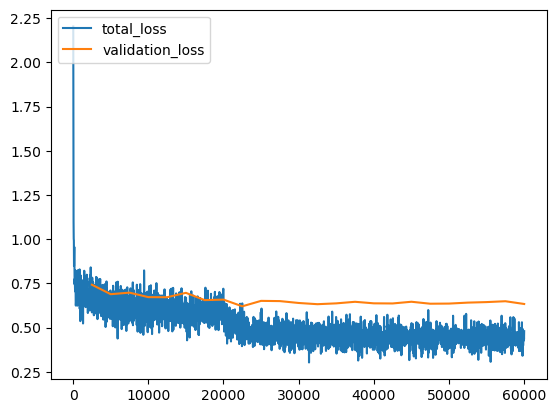

In [6]:
import json
import matplotlib.pyplot as plt

experiment_folder = 'SSLAD-2D/labeled/output/save'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

# Filter data points to include only those that have 'total_loss'
filtered_metrics = [x for x in experiment_metrics if 'total_loss' in x]

plt.plot(
    [x['iteration'] for x in filtered_metrics], 
    [x['total_loss'] for x in filtered_metrics])

# For validation_loss, already doing a filtering
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])

plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.show()


## Evaluation val

In [7]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer

# Set up the configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("soda10m_train",)
cfg.DATASETS.TEST = ("soda10m_val",)  # Provide the tuple even if no validation set is available
cfg.MODEL.WEIGHTS = r"SSLAD-2D/labeled/output/save2x/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a testing threshold
cfg.TEST.DETECTIONS_PER_IMAGE = 300  # Adjust as necessary
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Set the number of classes

# Build the test loader
test_loader = build_detection_test_loader(cfg, "soda10m_val")

# Create a COCOEvaluator instance
evaluator = COCOEvaluator("soda10m_val", cfg, False, output_dir=r"SSLAD-2D\labeled\output\save2x\inferenceVal")

# Initialize the trainer
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Count the number of parameters
total_params = sum(p.numel() for p in trainer.model.parameters())
print(f"Total number of parameters: {total_params}")

# Perform the evaluation
eval_results = inference_on_dataset(trainer.model, test_loader, evaluator)
print(eval_results)

[12/14 09:57:01 d2.data.datasets.coco]: Loaded 5000 images in COCO format from SSLAD-2D/labeled/annotations/instance_val.json
[12/14 09:57:02 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| Pedestrian | 2837         |  Cyclist   | 2624         |    Car     | 20648        |
|   Truck    | 9532         |    Tram    | 1391         |  Tricycle  | 97           |
|            |              |            |              |            |              |
|   total    | 37129        |            |              |            |              |
[12/14 09:57:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/14 09:57:02 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._T

[12/14 09:57:02 d2.data.datasets.coco]: Loaded 5000 images in COCO format from SSLAD-2D/labeled/annotations/instance_train.json
[12/14 09:57:03 d2.data.build]: Removed 33 images with no usable annotations. 4967 images left.
[12/14 09:57:03 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| Pedestrian | 4901         |  Cyclist   | 6548         |    Car     | 23456        |
|   Truck    | 4297         |    Tram    | 1681         |  Tricycle  | 227          |
|            |              |            |              |            |              |
|   total    | 41110        |            |              |            |              |
[12/14 09:57:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, samp

C:\Users\melmourabitagharbi\.conda\envs\p38_env\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/14 09:57:16 d2.evaluation.evaluator]: Inference done 46/5000. Dataloading: 0.0005 s/iter. Inference: 0.1118 s/iter. Eval: 0.0002 s/iter. Total: 0.1126 s/iter. ETA=0:09:17
[12/14 09:57:21 d2.evaluation.evaluator]: Inference done 90/5000. Dataloading: 0.0006 s/iter. Inference: 0.1128 s/iter. Eval: 0.0002 s/iter. Total: 0.1137 s/iter. ETA=0:09:18
[12/14 09:57:26 d2.evaluation.evaluator]: Inference done 134/5000. Dataloading: 0.0006 s/iter. Inference: 0.1133 s/iter. Eval: 0.0002 s/iter. Total: 0.1142 s/iter. ETA=0:09:15
[12/14 09:57:31 d2.evaluation.evaluator]: Inference done 178/5000. Dataloading: 0.0006 s/iter. Inference: 0.1136 s/iter. Eval: 0.0002 s/iter. Total: 0.1145 s/iter. ETA=0:09:12
[12/14 09:57:37 d2.evaluation.evaluator]: Inference done 222/5000. Dataloading: 0.0006 s/iter. Inference: 0.1140 s/iter. Eval: 0.0002 s/iter. Total: 0.1149 s/iter. ETA=0:09:08
[12/14 09:57:42 d2.evaluation.evaluator]: Inference done 266/5000. Dataloading: 0.0006 s/iter. Inference: 0.1142 s/iter. E

[12/14 10:01:04 d2.evaluation.evaluator]: Inference done 2097/5000. Dataloading: 0.0006 s/iter. Inference: 0.1101 s/iter. Eval: 0.0002 s/iter. Total: 0.1110 s/iter. ETA=0:05:22
[12/14 10:01:09 d2.evaluation.evaluator]: Inference done 2144/5000. Dataloading: 0.0006 s/iter. Inference: 0.1100 s/iter. Eval: 0.0002 s/iter. Total: 0.1109 s/iter. ETA=0:05:16
[12/14 10:01:14 d2.evaluation.evaluator]: Inference done 2191/5000. Dataloading: 0.0006 s/iter. Inference: 0.1099 s/iter. Eval: 0.0002 s/iter. Total: 0.1108 s/iter. ETA=0:05:11
[12/14 10:01:19 d2.evaluation.evaluator]: Inference done 2238/5000. Dataloading: 0.0006 s/iter. Inference: 0.1099 s/iter. Eval: 0.0002 s/iter. Total: 0.1108 s/iter. ETA=0:05:05
[12/14 10:01:24 d2.evaluation.evaluator]: Inference done 2285/5000. Dataloading: 0.0006 s/iter. Inference: 0.1098 s/iter. Eval: 0.0002 s/iter. Total: 0.1107 s/iter. ETA=0:05:00
[12/14 10:01:29 d2.evaluation.evaluator]: Inference done 2332/5000. Dataloading: 0.0006 s/iter. Inference: 0.1098 s

[12/14 10:04:51 d2.evaluation.evaluator]: Inference done 4210/5000. Dataloading: 0.0006 s/iter. Inference: 0.1085 s/iter. Eval: 0.0002 s/iter. Total: 0.1093 s/iter. ETA=0:01:26
[12/14 10:04:57 d2.evaluation.evaluator]: Inference done 4257/5000. Dataloading: 0.0006 s/iter. Inference: 0.1084 s/iter. Eval: 0.0002 s/iter. Total: 0.1093 s/iter. ETA=0:01:21
[12/14 10:05:02 d2.evaluation.evaluator]: Inference done 4304/5000. Dataloading: 0.0006 s/iter. Inference: 0.1084 s/iter. Eval: 0.0002 s/iter. Total: 0.1093 s/iter. ETA=0:01:16
[12/14 10:05:07 d2.evaluation.evaluator]: Inference done 4351/5000. Dataloading: 0.0006 s/iter. Inference: 0.1084 s/iter. Eval: 0.0002 s/iter. Total: 0.1093 s/iter. ETA=0:01:10
[12/14 10:05:12 d2.evaluation.evaluator]: Inference done 4398/5000. Dataloading: 0.0006 s/iter. Inference: 0.1084 s/iter. Eval: 0.0002 s/iter. Total: 0.1093 s/iter. ETA=0:01:05
[12/14 10:05:17 d2.evaluation.evaluator]: Inference done 4445/5000. Dataloading: 0.0006 s/iter. Inference: 0.1084 s

## Evaluation Test

In [5]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer

# Set up the configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("soda10m_train",)
cfg.DATASETS.TEST = ("soda10m_test",)  # Provide the tuple even if no validation set is available
cfg.MODEL.WEIGHTS = r"SSLAD-2D/labeled/output/save/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a testing threshold
cfg.TEST.DETECTIONS_PER_IMAGE = 300  # Adjust as necessary
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Set the number of classes

# Build the test loader
test_loader = build_detection_test_loader(cfg, "soda10m_test")

# Create a COCOEvaluator instance
evaluator = COCOEvaluator("soda10m_test", cfg, False, output_dir=r"SSLAD-2D\labeled\output\save\inferenceTest")

# Initialize the trainer
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Perform the evaluation
eval_results = inference_on_dataset(trainer.model, test_loader, evaluator)
print(eval_results)

[12/12 10:46:18 d2.data.datasets.coco]: Loaded 10000 images in COCO format from SSLAD-2D/labeled/annotations/instance_test.json
[12/12 10:46:18 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| Pedestrian | 0            |  Cyclist   | 0            |    Car     | 0            |
|   Truck    | 0            |    Tram    | 0            |  Tricycle  | 0            |
|            |              |            |              |            |              |
|   total    | 0            |            |              |            |              |
[12/12 10:46:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/12 10:46:18 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.

[12/12 10:46:19 d2.data.datasets.coco]: Loaded 5000 images in COCO format from SSLAD-2D/labeled/annotations/instance_train.json
[12/12 10:46:19 d2.data.build]: Removed 33 images with no usable annotations. 4967 images left.
[12/12 10:46:19 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| Pedestrian | 4901         |  Cyclist   | 6548         |    Car     | 23456        |
|   Truck    | 4297         |    Tram    | 1681         |  Tricycle  | 227          |
|            |              |            |              |            |              |
|   total    | 41110        |            |              |            |              |
[12/12 10:46:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, samp

KeyboardInterrupt: 

## Prediction

In [6]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# Load the validation dataset
dataset_dicts = DatasetCatalog.get("soda10m_val")
metadata = MetadataCatalog.get("soda10m_val")

# Assuming you want to visualize the ground truth for the first image in the dataset
img_dict = dataset_dicts[0]  # or any other index

# Load the image
image = cv2.imread(img_dict["file_name"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw ground truth annotations on the image
v_gt = Visualizer(image, metadata, scale=1.2)
out_gt = v_gt.draw_dataset_dict(img_dict)
im_gt = out_gt.get_image()

# Now `im_gt` contains the image with ground truth annotations


[12/18 14:44:59 d2.data.datasets.coco]: Loaded 5000 images in COCO format from SSLAD-2D/labeled/annotations/instance_val.json


In [7]:
# Configuration and model loading for Faster R-CNN
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = r"SSLAD-2D\labeled\output\save2x\model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Set this to the number of classes you have, same as during training


# Create predictor
predictor = DefaultPredictor(cfg)

# Make prediction
outputs = predictor(image)

# We use Visualizer to draw the predictions on the image.
v = Visualizer(image[:, :, ::-1], metadata, scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))


# OpenCV uses BGR color format, and matplotlib uses RGB.
# So, we need to convert the image from BGR to RGB format.
im_pred = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)


[12/18 14:45:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from SSLAD-2D\labeled\output\save2x\model_final.pth ...


C:\Users\melmourabitagharbi\.conda\envs\p38_env\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


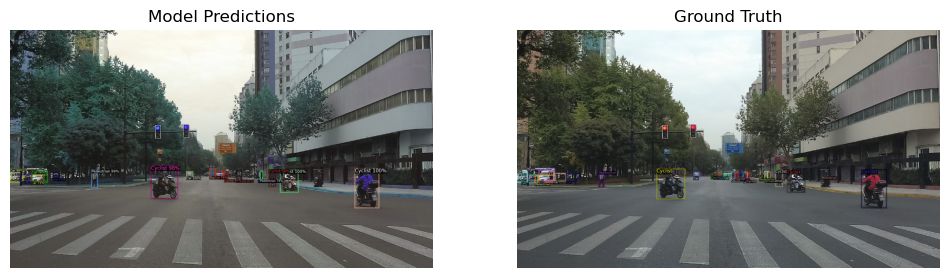

In [8]:
# Display predictions and ground truth side by side using matplotlib
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im_pred)
plt.title('Model Predictions')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im_gt)
plt.title('Ground Truth')
plt.axis('off')

# Save the figure to a file
plt.savefig("comparison_plot.png", bbox_inches='tight', dpi=300)
# Optionally, you can still display the plot if you want
plt.show()